In [1]:
%%capture
!pip install -q speechbrain
!pip install -q transformers
!pip install -q audio_classification_models
!pip install -q numpy scipy matplotlib librosa noisereduce
!pip install tqdm

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import pandas as pd #data structure for data processing
import numpy as np  #data structure for mathematical operations
import random       #getting random values
import os           #os related operations
import shutil       #file io
import librosa      #audio related operations like feature extraction
import matplotlib.pyplot as plt                   #graph plot
plt.rcParams["font.family"] = 'DejaVu Sans'       #set font, for some reason
import seaborn as sns                             #graph plot
sns.set_style("whitegrid", {'axes.grid' : False}) #set font,

import tensorflow as tf, re, math   #ml library, regular expression, math op
import tensorflow_addons as tfa     #tf+
import tensorflow.keras.backend as K #allows running on different backends (like tf, torch...)
import tensorflow_io as tfio         #io, preprocessing

import yaml                             #handle yaml files
from IPython import display as ipd      #display image, audio, video, html
import json                             #handle json file
from datetime import datetime           #date and time op

from glob import glob                   #file matching using wildcard patterns
from tqdm.notebook import tqdm          #create progress bars
import sklearn                          #data mining, data analysis, ml
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# we know what confusion matrix is. you can say the other ones are scores
from sklearn.model_selection import KFold    #cross validation score
from sklearn.metrics import roc_auc_score    #ml related score
# from IPython import display as ipd           #wrote that once

import itertools             #iterator opeations
import scipy                 #scientific calculation
import warnings              #handle warnings

import os
import torchaudio
from speechbrain.pretrained import SepformerSeparation as separator
import numpy as np
import noisereduce as nr
from IPython.display import Audio
import speechbrain
from tqdm import tqdm

E:\Anaconda\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
E:\Anaconda\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and su

In [3]:
pip install tensorflow_addons

In [3]:
def Audio2Spec(audio,spec_shape=[256, 128],sr=16000,nfft=2048,window=2048,fmin=20,fmax=8000):
    # spec shape definition
    spec_time = spec_shape[0]
    spec_freq = spec_shape[1]
    audio_len = tf.shape(audio)[0] #audio length
    # hop length is number of audio samples between successive frames
    hop_length = tf.cast((audio_len // (spec_time - 1)), tf.int32) # compute hop_length to keep desired spec_shape.
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length) # convert to spectrogram
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_freq, fmin=fmin, fmax=fmax) # transform to melscale
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80) # from power to db (log10) scale
    if tf.shape(db_mel_spec)[0] > spec_time:  # check if we have desiered shape
        db_mel_spec = db_mel_spec[:spec_time,:]  #if not, truncate
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)  #reshape to desired shape
    return db_mel_spec # get spectrogram in decibal scale of desired spec shape

In [42]:
def Spec2Img(spec, num_channels=1):
    # 1 channel image
    img = spec[..., tf.newaxis]
    # Copy same image across channel axis
    if num_channels>1:
        img = tf.tile(img, [1, 1, num_channels])
    return img

In [43]:
# Again, Akif bhai wrote it. I don't know the details
# It contains some values that might be useful in later cases
# probably the intention was to keep all values in one place and chaning the values if necessary
# not all values are used though

class CFG:
   
   
    # Model & Backbone
    model_name = "Conformer"

    # Audio params
    sample_rate = 16000
    duration = 3.5 # duration in second
    audio_len = int(sample_rate * duration)
    normalize = True

    # Spectrogram params
    spec_freq = 128 # freq axis
    n_fft = 2048
    spec_time = 256 # time axis
    hop_len = audio_len//(spec_time - 1) # non-overlap region
    fmin = 20
    fmax = sample_rate//2 # max frequency
    spec_shape = [spec_time, spec_freq] # output spectrogram shape
    
    # Audio Augmentation
    timeshift_prob = 0.0
    gn_prob = 0.0
    
    # Spectrogram Augmentation
    time_mask = 20
    freq_mask = 10
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    mixup_prob = 0.0
    mixup_alpha = 2.5

    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 12
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "categorical_crossentropy"
    optimizer = "AdamW"
    lr = 1e-4
    lr_schedule = "cosine"

    # Augmentation
    augment = False

    # Clip values to [0, 1]
    clip = False
    TRAIN_PATH = 'D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 312 Project\noise_reduce\preprocessed'

In [44]:
# again, written by Akif bhai, although i changed it quite a bit for me to use
# dataloader class which inherits the tf.keras.utils.Sequence class
# this class is used in model.fit at the end of the code
# this class must have __len__, __init__, __getitem__ and optionally on_epoch_end functions.
# __init__ is constructor, just initializes member variables
# __len__ returns number of batches. each batch contains a number of audio data, which is equal to the batch size
# __on_epoch_end__ runs at the end of each epoch. in here, the audio is shuffled when shuffle==True. I don't know if this can actually help in improving accuracy though
# __get_item__ returns the audio_data of (index)th batch. it create a list of indexes that will contruct the batch and calls __data_generation
# __data_generation function takes the list of indexes and make a list of audio using those indexes. makes spectogram, then image, then scales it (dividng by 255), one hot encodes output, finally returns x,y
# one hot encoding: in our case, our output is 0,1,2,3,...75 (you can say, speaker id). But one hot encoding transforms output into a list where...
# each output will be a list with 75 indices and all values of the list will be zero except for one. for example,...
# if outputs were 0,1,2 instead of 0-75, one hot encoded forms of 0, 1, 2  will be [1,0,0], [0,1,0], [0,0,1]. so,...
# prediction of model will also produce result in one hot encoded form. it is used because it may improve accuracy

class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, audio, output, batch_size=32, num_classes=3,
                 dim=(256, 128,1), shuffle=True):
        """Initialization method for the DataLoader class."""
        self.audio = audio
        self.output = output
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.audio) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        batch = self.__data_generation(batch_indexes)
        return batch
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.audio))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        if self.output is not None:
            y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load sample
            img = Audio2Spec(np.array(self.audio[idx], dtype=np.float32))
            
            img = Spec2Img(img)
            
            # Store Sample
            X[i,] = img
            
            # Store class
            if self.output is not None:
                y[i] = self.output[idx]
        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0
        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.output is not None:
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return X, y
        # if there is labels = None, then only return X
        return X

In [45]:
# this function returns a model, Akif bhai wrote it so i don't know the details

import audio_classification_models as acm

URL = 'https://github.com/awsaf49/audio_classification_models/releases/download/v1.0.8/conformer-encoder.h5'

def Conformer(input_shape=(128, 80, 3),num_classes=3, final_activation='sigmoid', pretrain=True):
    """Souce Code: https://github.com/awsaf49/audio_classification_models"""
    inp = tf.keras.layers.Input(shape=input_shape)
    backbone = acm.ConformerEncoder()
    out = backbone(inp)
    if pretrain:
        acm.utils.weights.load_pretrain(backbone, url=URL)
    out = tf.keras.layers.GlobalAveragePooling1D()(out)
#     out = tf.keras.layers.Dense(32, activation='selu')(out)
    out = tf.keras.layers.Dense(num_classes, activation=final_activation)(out)
    model = tf.keras.models.Model(inp, out)
    return model

In [46]:
def get_model(name=CFG.model_name, loss=CFG.loss,):
    model = Conformer(input_shape=[*CFG.spec_shape,1],pretrain=True)
    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")
    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=['accuracy']
    )
    return model

In [47]:
# you have seen this before in the deep learning playlist, so i am not saying anything about it

#model = get_model()
model = Conformer(input_shape=[*CFG.spec_shape,1],pretrain=True)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.001,weight_decay = 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 128, 1)]     0         
                                                                 
 conformer_encoder (Conform  (None, None, 144)         8959680   
 erEncoder)                                                      
                                                                 
 global_average_pooling1d_3  (None, 144)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 3)                 435       
                                                                 
Total params: 8960115 (34.18 MB)
Trainable params: 8955507 (34.16 MB)
Non-trainable params: 4608 (18.00 KB)
_________________________________________________________________


In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    verbose=1,
    restore_best_weights=True
    )

In [49]:
def get_lr_callback(mode='exp', batch_size=64, epochs=30, plot=False):
    """adapted from @cdeotte"""
    lr_start = 5e-5
    lr = 0.001 # base_lr
    lr_max = 5e-4 # max lr - will be multiplied by batch_size
    lr_min = 0.1e-4 # min lr
    lr_ramp_ep = 4 # warming up epochs
    lr_sus_ep = 0 # sustain epochs lr after warming up
    lr_decay = 0.8 # decay rate

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif mode == 'cosine':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(
            np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch')
        plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

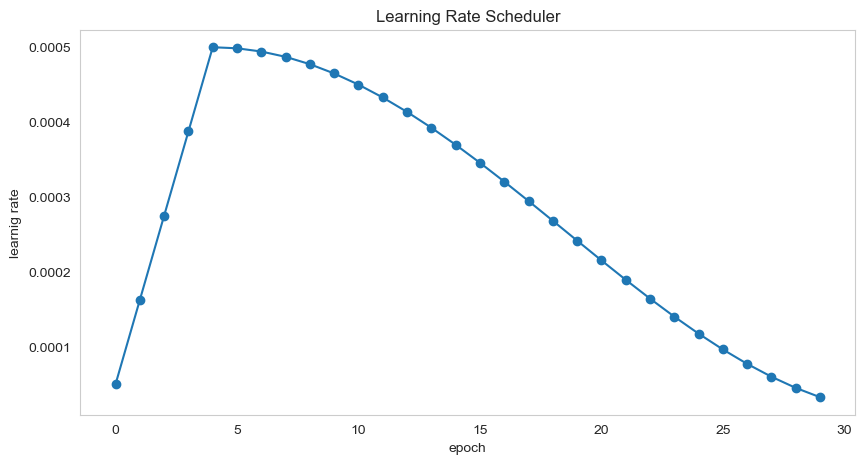

In [50]:
lr_callback = get_lr_callback(mode=CFG.lr_schedule,epochs=30,plot=True)

In [51]:
callbacks = [early_stopping,get_lr_callback(mode=CFG.lr_schedule,epochs=CFG.epochs)]

In [52]:
def makePdFromData (train_path):
    audio_path_list = os.listdir(train_path)
    df = pd.DataFrame(audio_path_list, columns=['FilePath'])
    df['SpeakerID'] = df['FilePath'].apply(lambda x: int(x.split('-')[0].split('_')[1]))
    df['FilePath'] = df['FilePath'].apply(lambda x: train_path + str(x))
    return df

In [53]:
def mergeAndDivideAudioOfSameSpeaker (df, time_per_sample, train_percentage):
    train_audio = []
    train_y = []
    test_audio = []
    test_y = []
    with tqdm(total=len(df), desc="Loading...") as pbar:
        for speaker_id in df['Person_ID'].unique():
            # for each speaker id, take all audio of that speaker
            speaker_rows = df[df['Person_ID'] == speaker_id]
            sr=0
            full_audio = np.array([])
            for path in speaker_rows['Audio Path']:
                # load audio
                audio,sr = librosa.load(path, sr = 8000)
                # merge audio of the speaker
                full_audio = np.concatenate((full_audio,audio),axis=0)
                pbar.update(1)
            # now, we have all audio of the speaker merged inside full_audio function
            # next, out task is to split the full_audio
            sample_per_sound = time_per_sample * sr     # how many sample in a time_per_sample second
            full_audio = np.concatenate((full_audio, full_audio[:int(sample_per_sound - len(full_audio) % sample_per_sound)]), axis=0) # adding the starting part of fullaudio in the end to make it a multiple of sample_per_sound
            audiolist_of_speaker = []
            for i in range (0, int(len(full_audio)//sample_per_sound)):
                new_audio = full_audio[int(i*sample_per_sound):int((i+1)*sample_per_sound-1)]     # takes a part of full_audio
                audiolist_of_speaker.append(new_audio)                                  # appends this audio in audiolist_of_speaker
            #random.shuffle(audiolist_of_speaker)        #shuffles it because why not
            # now we have a list of audio of that speaker each of which is of duration equal to time_per_sample
            # our next task is to take train_percentage amount of data into training dataset and rest into testing
            train_count = len(audiolist_of_speaker)*train_percentage//100           # number of train set
            train_audio = train_audio + audiolist_of_speaker[:train_count]          # train_audio
            test_audio = test_audio + audiolist_of_speaker[train_count:]            # test_audio
            train_y = train_y + [int(speaker_id) for i in range(train_count)]                           # train output, which should be between 0 and 75. so, 2 became 0, 3 became 1,... etc and 77 became 5
            test_y = test_y + [int(speaker_id) for i in range(len(audiolist_of_speaker)-train_count)]   # test output
    return train_audio, train_y, test_audio, test_y, sr

In [54]:
df = pd.read_csv(r'D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 312 Project\noise_reduce\\new.csv')
train_audio, train_y, test_audio, test_y, sr = mergeAndDivideAudioOfSameSpeaker(df, 0.5, 80)

Loading...: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.33it/s]


In [55]:
# just shuffles two lists together

import random
def dual_shuffle (list1, list2):
    combined_lists = list(zip(list1, list2))
    random.shuffle(combined_lists)
    return zip(*combined_lists)
train_audio, train_y = dual_shuffle(train_audio, train_y)
test_audio, test_y = dual_shuffle(test_audio, test_y)

In [56]:
df

,Unnamed: 0,Person,Audio Path,Person_ID
0,0,Ayman,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,0
1,1,Ayman,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,0
2,2,Ayman,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,0
3,3,EC,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,1
4,4,EC,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,1
5,5,EC,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,1
6,6,EC,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,1
7,7,munjerin,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,2
8,8,munjerin,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,2
9,9,munjerin,D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 3...,2


In [57]:
train_loader = DataLoader(train_audio, train_y, batch_size=32)
valid_loader = DataLoader(test_audio, test_y, batch_size=16, shuffle=False)

In [ ]:
# finally, the model.fit

model.fit(
    train_loader,
    epochs=4,
    #callbacks=callbacks,
    validation_data=valid_loader,
    verbose=True,
)

Epoch 1/4




In [24]:
from collections import Counter
def DivideAudiomakeprediction (y, sr, time_per_sample=1):
    test_x = []
    sample_per_sound = time_per_sample * sr
    for i in range (0, int(len(y)//sample_per_sound)):
        new_audio = y[int(i*sample_per_sound):int((i+1)*sample_per_sound-1)]     # takes a part of full_audio
        test_x.append(new_audio) 
    
    X_test=[]
    for sample in test_x:
        img = Audio2Spec(np.array(sample, dtype=np.float32))
        img = Spec2Img(img)
        X_test.append(img)
    verdict=[]
    for sample in X_test:
        # Make predictions
        single_sample = np.expand_dims(sample, axis=0)
        y_pred = model.predict(single_sample)

        # Convert predictions to class indices
        y_pred_class = np.argmax(y_pred, axis=1)
        verdict.append(y_pred_class)
    
#     # Count occurrences of each integer
#     counter = Counter(verdict)

#     # Find the most common integer and its count
#     most_common_integer, max_count = counter.most_common(1)[0]

    return verdict

In [25]:
#nonsilent frame decomposition
from librosa import core
from librosa import feature
from typing import Any,Callable,Tuple,Union

def signal_to_frame_nonsilent(
    y: np.ndarray,
    frame_length: int = 2048,
    hop_length: int = 512,
    top_db: float = 60,
    ref: Union[Callable, float] = np.max,
    aggregate: Callable = np.max,
) -> np.ndarray:
    # Compute the MSE for the signal
    mse = feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)

    # Convert to decibels and slice out the mse channel
    db: np.ndarray = core.amplitude_to_db(mse[..., 0, :], ref=ref, top_db=None)
    
    # Aggregate everything but the time dimension
#     if db.ndim > 1:
#         db = np.apply_over_axes(aggregate, db, range(db.ndim - 1))
#         # Squeeze out leading singleton dimensions here
#         # We always want to keep the trailing dimension though
#         db = np.squeeze(db, axis=tuple(range(db.ndim - 1)))
    return db>-top_db

#splitting the non silent frames and return as array of array
def split(
    y: np.ndarray,
    *,
    top_db: float = 60,
    ref: Union[float, Callable] = np.max,
    frame_length: int = 2048,
    hop_length: int = 512,
    aggregate: Callable = np.max,
) -> np.ndarray:
    
    non_silent = signal_to_frame_nonsilent(
        y,
        frame_length=frame_length,
        hop_length=hop_length,
        ref=ref,
        top_db=top_db,
        aggregate=aggregate,
    )

    edges = np.flatnonzero(np.diff(non_silent.astype(int)))

    edges = [edges + 1]

    # If the first frame had high energy, count it
    if non_silent[0]:
        edges.insert(0, np.array([0]))

    # Likewise for the last frame
    if non_silent[-1]:
        edges.append(np.array([len(non_silent)]))

    # Convert from frames to samples
    edges = core.frames_to_samples(np.concatenate(edges), hop_length=hop_length)

    # Clip to the signal duration
    edges = np.minimum(edges, y.shape[-1])

    # Stack the results back as an ndarray
    edges = edges.reshape((-1, 2))  # type: np.ndarray
    return edges

def remove_silence(audio,top_db=40):
    clips = split(audio, top_db = top_db)
    #print(clips)
    wav_data = []
    for c in clips:
        #print(c)
        data = audio[c[0]: c[1]]
        wav_data.extend(data)
    return np.array(wav_data)

In [26]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import sequence
import librosa
from collections import Counter

num_labels=5
# Load the pre-trained model
coeff=0.97
top_db=45
y,sr=librosa.load(r'D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 312 Project\noise_reduce\preprocessed\\Enayet.wav',sr=8000)
y = np.append(y[0], y[1:] - coeff * y[:-1])
y/=np.abs(y).max()
y = np.array(remove_silence(y, top_db=top_db))
t=DivideAudiomakeprediction (y, sr)

list=[]
for i in range(num_labels):
    list.append(t.count(i))

print(list)
highest_number = max(list)

# Find the index of the highest number
classe = list.index(highest_number)
# print(classe)

speaker_rows = df[df['Person_ID'] == classe]
print(speaker_rows['Person'])

C:\Users\Nittya\AppData\Local\Temp\ipykernel_23484\1660027232.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y,sr=librosa.load(r'D:\OneDrive - BUET\OneDrive - BUET\L3_T1\EEE 312 Project\noise_reduce\preprocessed\\Enayet.wav',sr=8000)
E:\Anaconda\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\OneDrive - BUET\\OneDrive - BUET\\L3_T1\\EEE 312 Project\\noise_reduce\\preprocessed\\\\Enayet.wav'